In [3]:
# Modified: 25/10/2020 by DD
#
# In this quick start practical tutorial, you will learn how to get the power factors from S1 Level-1 GRD data.
# The processing comprises two stages. 1st is related to the method called 'experiment_powerBalancing'
# of the 'Sentinel1Image' class to obtain statistics for an each individual training file.
# The aggregated statistics processing is the second stage of the method and implemnted as a
# python script called 'analyze_experiment_powerBalancingParameters.py'.
# In this tutorial we follow the mentioned implementation almost line by line.

In [4]:
# Pre-requerments: It is assumed that you have dowmloaded and installed Sentinel1Denoised package:
# https://github.com/nansencenter/sentinel1denoised/tree/master

In [5]:
########################################################################
# Stage 1. Processing of individual training files (S1 Level-1 GRD)  #
########################################################################

In [6]:
# First you need to import Sentinel1Image class and open 
# a S1 Level1 GRD file (IW GRDH in our case, replace with yours)
# Note: In our example we process the only one training file but in real data processing you need to use tens of files
# in batch manner

from s1denoise import Sentinel1Image
import numpy as np
s1 = Sentinel1Image('/mnt/sverdrup-2/sat_auxdata/denoise/dolldrums/zip/S1A_IW_GRDH_1SDV_20200607T075151_20200607T075220_032908_03CFD7_9E14.zip')

04:05:16|40|nansat|_get_dataset_metadata|GDAL could not open /mnt/sverdrup-2/sat_auxdata/denoise/dolldrums/zip/S1A_IW_GRDH_1SDV_20200607T075151_20200607T075220_032908_03CFD7_9E14.zip, trying to read with Nansat mappers...


In [7]:
# We further go almost in line by line manner through the method called 'experiment_powerBalancing'

In [8]:
# Clip size of side pixels, ~1km
cPx = {'IW':100, 'EW':25}[s1.obsMode]
# Define polarization of the data we want to process
polarization = 'VH'

In [9]:
# Call 'subswathIndexMap' method to get matrix with sub-swath numbers
# consistent with the data grid
subswathIndexMap = s1.subswathIndexMap(polarization)

In [10]:
# Print out the matrix
subswathIndexMap

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]], dtype=uint8)

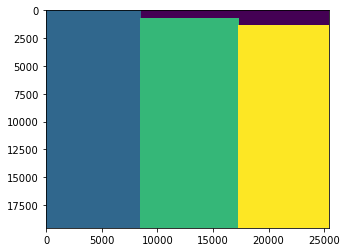

In [11]:
# Lets visualize the sub-swath numbers
# Color corresponds to different sub-swath. In our case:
# blue - 1, green - 2, yellow - 3, black - no data
import matplotlib.pyplot as plt
plt.clf()
plt.imshow(subswathIndexMap)

In [12]:
# To mask areas over land, we call 'landmask' method
landmask = s1.landmask(skipGCP=4)

In [13]:
# Get matrices of calibrated raw sigma zero and NESZ from ESA-provided annotaion files
sigma0 = s1.rawSigma0Map(polarization)
noiseEquivalentSigma0 = s1.rawNoiseEquivalentSigma0Map(polarization, lutShift=True)
# Make a copy of the raw noise matrix
rawNoiseEquivalentSigma0 = noiseEquivalentSigma0.copy()        

In [14]:
# Import the noise scaling coefficients and scale the noise
# to a matrix called 'noiseEquivalentSigma0'
# The scaling is applied separetely for each sub-swath

noiseScalingParameters = s1.import_denoisingCoefficients(polarization)[0]

for iSW in range(1, {'IW':3, 'EW':5}[s1.obsMode]+1):
    valid = (subswathIndexMap==iSW)
    noiseEquivalentSigma0[valid] *= noiseScalingParameters['%s%s' % (s1.obsMode, iSW)]

In [15]:
# Get the line indexes where we have data for each element in range ditrection
import numpy as np
validLineIndices = np.argwhere(np.sum(subswathIndexMap!=0,axis=1)==s1.shape()[1])

In [16]:
# Define number of lines to averge (block height), in our case 1000 px
# and calculate the block bounds
numberOfLinesToAverage = 1000
blockBounds = np.arange(validLineIndices.min(), validLineIndices.max(),
                                numberOfLinesToAverage, dtype='uint')

In [17]:
# Print out block bounds coordinates (pixel indexes)
blockBounds

array([ 1367,  2367,  3367,  4367,  5367,  6367,  7367,  8367,  9367,
       10367, 11367, 12367, 13367, 14367, 15367, 16367, 17367, 18367,
       19367], dtype=uint64)

In [18]:
# Prepare a dictonary for results for each sub-block
# sigma0 is a vector with the mean range profile
# noiseEquivalentSigma0 is a vector with the mean range profile of ESA-provided noise
# balancingPower is a value of intermediate balancing power
# correlationCoefficient is a value of correlation coefficient between raw sigma0 and the scaled noise
# fitResidual is a value of optimization residual
results = { '%s%s' % (s1.obsMode, li):
                        { 'sigma0':[],
                          'noiseEquivalentSigma0':[],
                          'balancingPower':[],
                          'correlationCoefficient':[],
                          'fitResidual':[] }
                    for li in range(1, {'IW':3, 'EW':5}[s1.obsMode]+1) }

In [51]:
# Loop over blocks
for iBlk in range(len(blockBounds)-1):
    # Check if there is no pixels over land areas
    if landmask[blockBounds[iBlk]:blockBounds[iBlk+1]].sum() != 0:
        continue
    
    # Slicing 2D arrays for each block
    # sigma0
    blockS0 = sigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]   
    # Scaled noise
    blockN0 = noiseEquivalentSigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    # Raw ESA noise
    blockRN0 = rawNoiseEquivalentSigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    # Sub-swath indices for the block
    blockSWI = subswathIndexMap[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    
    # An arbitrary empirical adjustment.
    # When the number of valid range pixels is too small, it is hard to get reliable estimation.
    # By allowing the use of some pixels with negative values, the number of range pixels to be used 
    # for fitting increases.
    # In short, it can be any value but we set it as 0.5 for no special reason.
    pixelValidity = (np.nanmean(blockS0 - blockRN0 * 0.5, axis=0) > 0) 
    if pixelValidity.sum() <= (blockS0.shape[1] * 0.9):
        continue

    fitCoefficients = []
    
    # Loop over sub-blocks
    for iSW in range(1, {'IW': 3, 'EW': 5}[s1.obsMode]+1):
        subswathID = '%s%s' % (s1.obsMode, iSW)
        # Get valid pixel indices based on 'pixelValidity'
        pixelIndex = np.nonzero((blockSWI==iSW).sum(axis=0) * pixelValidity)[0][cPx:-cPx]
        if pixelIndex.sum()==0:
            continue
            
        # Compute vectors with mean range profiles for sub-block by averaging in azimuth direction
        meanS0 = np.nanmean(np.where(blockSWI==iSW, blockS0, np.nan), axis=0)[pixelIndex]
        meanN0 = np.nanmean(np.where(blockSWI==iSW, blockN0, np.nan), axis=0)[pixelIndex]
        meanRN0 = np.nanmean(np.where(blockSWI==iSW, blockRN0, np.nan), axis=0)[pixelIndex]
        
        # Do fitting for a difference between sigma0 and scaled noise
        fitResults = np.polyfit(pixelIndex, meanS0 - meanN0, deg=1, full=True)
        
        # Store slope value for further calculations
        fitCoefficients.append(fitResults[0])
        
        # Store results
        results[subswathID]['sigma0'].append(meanS0)
        results[subswathID]['noiseEquivalentSigma0'].append(meanRN0)
        results[subswathID]['correlationCoefficient'].append(np.corrcoef(meanS0, meanN0)[0,1])
        results[subswathID]['fitResidual'].append(fitResults[1].item())
    
    # Initialize a vector with zeros for each sub-swath 
    balancingPower = np.zeros({'IW': 3, 'EW': 5}[s1.obsMode])

    # Loop over sub-swath margins
    for li in range(len(s1.import_swathBounds(polarization))-1):
        # Calculate pixel coordinate of interswath boundary
        interswathBounds = (np.where(np.gradient(blockSWI, axis=1) == 0.5)[1]
                            .reshape(2 * numberOfLinesToAverage, 2)[li::4].mean())
        # Compute power value left to a boundary as slope*interswathBounds + residual coef.
        power1 = fitCoefficients[li][0] * interswathBounds + fitCoefficients[li][1]
        # Compute power value right to a boundary as slope*interswathBounds + residual coef.
        power2 = fitCoefficients[li+1][0] * interswathBounds + fitCoefficients[li+1][1]
        # Compute balancing power vector as a power difference between the powers in neighboring sub-swaths
        balancingPower[li+1] = power2 - power1
        
    # Compute cumulative sum vector of of the balancing power near sub-swath margins
    balancingPower = np.cumsum(balancingPower)

    # Loop through sub-swaths to offset noise power for the each one
    for iSW in range(1, {'IW':3, 'EW':5}[s1.obsMode]+1):
        valid = (blockSWI==iSW)
        blockN0[valid] += balancingPower[iSW-1]

    # Value of the mean of the difference bewtween noise matrices for block across sub-swaths >=2
    powerBias = np.nanmean((blockRN0-blockN0)[blockSWI>=2])
    
    # Add the mean to the balancing power vector
    balancingPower += powerBias

    for iSW in range(1, {'IW':3, 'EW':5}[s1.obsMode]+1):
        results['%s%s' % (s1.obsMode, iSW)]['balancingPower'].append(balancingPower[iSW-1])

# Save results for individual file in NPZ format
np.savez(s1.name.split('.')[0] + '_powerBalancing.npz', **results)

# At this point we obtained statistics for many files and ready for the 2nd stage that is
# aggregated statistics processing

In [50]:
################################################
# Stage 2. Processing of aggregated statistics
################################################

In [52]:
# Once we have statistics for the training files we may start to get final results on the power balancing

In [135]:
# Initialize empty lists for results from each npz file
powerDifference = []
balancingPower = []
correlationCoefficient = []
fitResidual = []

In [136]:
# Get the list of npz files with individual statistics
import glob
npzFiles = glob.glob('*powerBalancing*.npz')

# Loop over the files
for npzFile in npzFiles:
    print('importing %s' % npzFile)
    npz = np.load(npzFile)
    npz.allow_pickle = True
    # Number of sub-blocks in sub-swath
    numberOfSubblocks = np.unique([ len(npz['%s%s' % (s1.obsMode,iSW)].item()['balancingPower'])
                                    for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode]+1)) ])
    
    # Check if a number of sub-blocks are not consistent for all subswaths
    if numberOfSubblocks.size != 1:
        print('*** numberOfSubblocks are not consistent for all subswaths.')
        continue
    
    # Unpack the number of sub-blocks
    numberOfSubblocks = numberOfSubblocks.item()
    
    # Loop over each sub-block
    for li in range(numberOfSubblocks):
        # Values of intermediate sigma0
        powerDifference.append([
              np.nanmean(10*np.log10(npz['%s%s' % (s1.obsMode,iSW)].item()['sigma0'][li]))
            - np.nanmean(10*np.log10(npz['%s%s' % (s1.obsMode,iSW)].item()['noiseEquivalentSigma0'][li]))
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])
        
        # Values of balancing power
        balancingPower.append([
            npz['%s%s' % (s1.obsMode,iSW)].item()['balancingPower'][li]
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])
        
        # Values of balancing correlation coefficient
        correlationCoefficient.append([
            npz['%s%s' % (s1.obsMode,iSW)].item()['correlationCoefficient'][li]
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])
        
        # Values of residuals
        fitResidual.append([
            npz['%s%s' % (s1.obsMode,iSW)].item()['fitResidual'][li]
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])

importing S1A_IW_GRDH_1SDV_20200607T075151_20200607T075220_032908_03CFD7_9E14_powerBalancing.npz


In [137]:
# After the loop, convert the aggregated lists to Numpy arrays
powerDifference = np.array(powerDifference)
balancingPower = np.array(balancingPower)
correlationCoefficient = np.array(correlationCoefficient)
fitResidual = np.array(fitResidual)

In [138]:
# Now we ready to compute fit values for each sub-swath based on aggregated statistics which are the power balancing factors
# and their confident intervals
powerBalancingParameters = {'%s%s' % (s1.obsMode,li): {} for li in range(1,({'IW': 3, 'EW': 5}[s1.obsMode]+1))}
powerBalancingParametersRMSE = {'%s%s' % (s1.obsMode,li): {} for li in range(1,({'IW': 3, 'EW': 5}[s1.obsMode]+1))}

In [139]:
# Compute vectors which are the mean across all sub-swath for each sub-block
pd = np.mean(powerDifference, axis=1)
cc = np.min(correlationCoefficient, axis=1)
fr = np.max(fitResidual, axis=1)
# Vector of weight factor for fitting
w = cc / fr

In [144]:
# Loop over sub-swaths for fitting vectors of mean values of power difference across all sub-swaths
# with balanacing power vector for a given sub-swath
for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1):
    bp = balancingPower[:,iSW-1]
    fitResults = np.polyfit(pd, bp, deg=0, w=w)
    powerBalancingParameters['%s%s' % (s1.obsMode,iSW)] = fitResults[0]
    powerBalancingParametersRMSE['%s%s' % (s1.obsMode,iSW)] = np.sqrt(np.sum((fitResults[0]-bp)**2 * w) / np.sum(w))

In [149]:
# Now we finished with the whole processing chain and obtained the power balancing factors for each sub-swath
# and their RMSE (can be considered as confident inetrval for the factor)
print('Power balancing factors:\n%s' % powerBalancingParameters)
print('\nRMSE of the power balancing factors:\n%s' % powerBalancingParametersRMSE)

Power balancing factors:
{'IW1': -1.0451947905660605e-05, 'IW2': -6.7062000939026225e-06, 'IW3': -3.3315781353876107e-05}

RMSE of the power balancing factors:
{'IW1': 2.0898092889664977e-05, 'IW2': 9.746197987689682e-06, 'IW3': 4.718598381744112e-05}
